In [1]:
# !pip install opencv-python
# !pip install matplotlib
# !pip install scikit-image
# !pip install torch
# !pip install torch-vision
# !pip install tqdm

In [4]:
import collections
import pathlib
import random
import pickle
from typing import Dict, Tuple, Sequence

import cv2
from skimage.color import rgb2lab, lab2rgb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.autograd import Variable

device = "cuda" if torch.cuda.is_available() else "cpu"

### Load Dataset

In [5]:
!ls /datasets/dribbble/dribbble

!unzip -o /datasets/dribbble/dribbble.zip -d /datasets/dribbble
import zipfile
with zipfile.ZipFile("/datasets/dribbble_half/dribbble_half.zip", 'r') as zip_ref:
    zip_ref.extractall("/datasets/dribbble_half")

ls: cannot access '/datasets/dribbble/dribbble': No such file or directory
unzip:  cannot find or open /datasets/dribbble/dribbble.zip, /datasets/dribbble/dribbble.zip.zip or /datasets/dribbble/dribbble.zip.ZIP.


FileNotFoundError: [Errno 2] No such file or directory: '/datasets/dribbble_half/dribbble_half.zip'

In [4]:
# image_to_palette: image -> corresponding palettes
image_to_palette = collections.defaultdict(set)

with open("/datasets/dribbble/dribbble/dribbble_designs - dribbble_designs.tsv", 'r') as tsvfile:
    for line in tsvfile:
        # print(line.strip().split('\t')) # ['uid', 'url', 'media_path', 'description', 'comments', 'tags', 'color_palette', 'likes', 'saves', 'date', 'collection_time', 'write_date']
        _, _, media_path, _, _, _, color_palette, *_ = line.strip().split('\t')
        media_filename = media_path.split('/')[-1]
        image_to_palette[media_filename] = set(color_palette[1:-1].split(','))

In [5]:
# get data
#    - visualize image
#    - visualize the color palette

def viz_color_palette(hexcodes):
    """
    visualize color palette
    """
    hexcodes = list(hexcodes)
    while len(hexcodes) < 6:
        hexcodes = hexcodes + hexcodes
    hexcodes = hexcodes[:6]
    
    palette = []
    for hexcode in hexcodes:
        rgb = np.array(list(int(hexcode.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))
        palette.append(rgb)

    palette = np.array(palette)[np.newaxis, :, :]
    return palette


def viz_image(path, image_to_palette: Dict):
    """
    visualize image
    visualize palette (using image_to_palette)
    """
    assert pathlib.Path(path).name in image_to_palette
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    palette = viz_color_palette(image_to_palette[pathlib.Path(path).name])
    
    # visualize image
    plt.imshow(img)
    plt.show()
    
    # visualize color palette
    print(palette.shape)
    plt.imshow(palette)
    # print(palette.shape)
    plt.axis('off')
    plt.show()

    return


pathlist = pathlib.Path("/datasets/dribbble_half/dribbble_half/data").glob("*.png")
for path in pathlist:
    viz_image(path, image_to_palette)
    break

### Generate Dataset

In [ ]:
# generate augmented images for training
#    - input/: images with original palette
#    - output/: images with new palette
#    - old_palette/: pickled files of original palette 
#    - new_palette/: pickled files of new palette 

def augment_image(img, title, hue_shift):
    # plt.imshow(img)
    # plt.title(f"Original {title} (in RGB)")
    # plt.show()

    # RGB -> HSV -> hue-shift 
    img_HSV = matplotlib.colors.rgb_to_hsv(img)
    a_2d_index = np.array([[1,0,0] for _ in range(img_HSV.shape[1])]).astype('bool')
    img_HSV[:, a_2d_index] = (img_HSV[:, a_2d_index] + hue_shift) % 1

    new_img = matplotlib.colors.hsv_to_rgb(img_HSV).astype(int)
    # plt.imshow(new_img)
    # plt.title(f"New {title} (in RGB)")
    # plt.show()

    # fixed original luminance
    img = img.astype(np.float) / 255.0
    new_img = new_img.astype(np.float) / 255.0
    ori_img_LAB = rgb2lab(img)
    new_img_LAB = rgb2lab(new_img)
    new_img_LAB[:, :, 0] = ori_img_LAB[:, :, 0]
    new_img_augmented = (lab2rgb(new_img_LAB)*255.0).astype(int)
    # plt.imshow(new_img_augmented)
    # plt.title(f"New {title} (in RGB) with Fixed Luminance")
    # plt.show()
    # plt.close()

    return new_img_augmented

pathlist = pathlib.Path("/datasets/dribbble_half/dribbble_half/data").glob("*.png")
for i, path in enumerate(pathlist):
    print(i)
    assert pathlib.Path(path).name in image_to_palette
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    palette = viz_color_palette(image_to_palette[pathlib.Path(path).name])

    hue_shift = random.random()
    augmented_image = augment_image(img, "Image", hue_shift)
    augmented_palette = augment_image(palette, "Palette", hue_shift)

    cv2.imwrite(f'data/train/input/{path.name}', img)
    pickle.dump(palette, open(f'data/train/old_palette/{path.stem}.pkl', 'wb'))
    cv2.imwrite(f'data/train/output/{path.name}', augmented_image)
    pickle.dump(augmented_palette, open(f'data/train/new_palette/{path.stem}.pkl', 'wb'))

### Feature Encoder (FE) and Recoloring Decoder (RD)

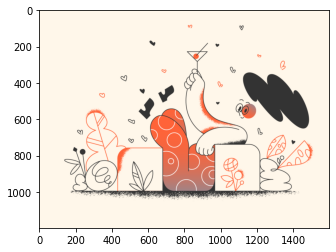

In [6]:
image = cv2.imread("/home/jovyan/work/data/train/input/0a02bab21de25f3ea1345dacf2a23300.png")
plt.imshow(image)
plt.show()

In [7]:
from functools import partial
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)  

def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.InstanceNorm2d(out_channels))

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
    
class ResNetLayer(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

class FeatureEncoder(nn.Module):
    def __init__(self):
        super(FeatureEncoder, self).__init__()

        # convolutional
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.norm1_1 = nn.InstanceNorm2d(64)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # residual blocks
        self.res1 = ResNetLayer(64, 128, block=ResNetBasicBlock, n=1)
        self.res2 = ResNetLayer(128, 256, block=ResNetBasicBlock, n=1)
        self.res3 = ResNetLayer(256, 512, block=ResNetBasicBlock, n=1)
    
    def forward(self, x):
        x = F.relu(self.norm1_1(self.conv1_1(x)))
        c4 = self.pool1(x)
        c3 = self.res1(c4)
        c2 = self.res2(c3)
        c1 = self.res3(c2)
        return c1, c2, c3, c4

In [8]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.InstanceNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.InstanceNorm2d(out_channels),
    )   

class RecoloringDecoder(nn.Module):
    # c => (bz, channel, h, w)
    # [Pt, c1]: (18 + 512) -> (256)
    # [c2, d1]: (256 + 256) -> (128)
    # [Pt, c3, d2]: (18 + 128 + 128) -> (64)
    # [Pt, c4, d3]: (18 + 64 + 64) -> 64
    # [Illu, d4]: (1 + 64) -> 3

    def __init__(self):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up_4 = double_conv(18 + 512, 256)
        self.dconv_up_3 = double_conv(256 + 256, 128)
        self.dconv_up_2 = double_conv(18 + 128 + 128, 64)
        self.dconv_up_1 = double_conv(18 + 64 + 64, 64)
        self.conv_last = nn.Conv2d(1 + 64, 3, 3, padding=1) 
        
        
    def forward(self, c1, c2, c3, c4, target_palettes_1d, illu):
        bz, h, w = c1.shape[0], c1.shape[2], c1.shape[3]
        target_palettes = torch.ones(bz, 18, h, w).float().to(device)
        target_palettes = target_palettes.reshape(h, w, bz * 18) * target_palettes_1d
        target_palettes = target_palettes.permute(2, 0, 1).reshape(bz, 18, h, w)

        # concatenate target_palettes with c1
        x = torch.cat((c1.float(), target_palettes.float()), 1)
        x = self.dconv_up_4(x)
        x = self.upsample(x)

        # concatenate c2 with x
        x = torch.cat([c2, x], dim=1)
        x = self.dconv_up_3(x)
        x = self.upsample(x)   

        # concatenate target_palettes and c3 with x
        bz, h, w = x.shape[0], x.shape[2], x.shape[3]
        target_palettes = torch.ones(bz, 18, h, w).float().to(device)
        target_palettes = target_palettes.reshape(h, w, bz * 18) * target_palettes_1d
        target_palettes = target_palettes.permute(2, 0, 1).reshape(bz, 18, h, w)
        x = torch.cat([target_palettes.float(), c3, x], dim=1)      
        x = self.dconv_up_2(x)
        x = self.upsample(x)  

        # concatenate target_palettes and c4 with x
        bz, h, w = x.shape[0], x.shape[2], x.shape[3]
        target_palettes = torch.ones(bz, 18, h, w).float().to(device)
        target_palettes = target_palettes.reshape(h, w, bz * 18) * target_palettes_1d
        target_palettes = target_palettes.permute(2, 0, 1).reshape(bz, 18, h, w)
        x = torch.cat([target_palettes.float(), c4, x], dim=1) 
        x = self.dconv_up_1(x)
        x = self.upsample(x)  
        illu = illu.view(illu.size(0), 1, illu.size(1), illu.size(2))
        x = torch.cat((x, illu), dim = 1)
        x = self.conv_last(x)
        return x

In [9]:
from torch.utils.data import Dataset, DataLoader
import pathlib

def get_illuminance(img):
    """
    Get the luminance of an image. Shape: (h, w)
    """
    img = img.permute(1, 2, 0)  # (h, w, channel) 
    img = img.numpy()
    img = img.astype(np.float) / 255.0
    img_LAB = rgb2lab(img)
    img_L = img_LAB[:,:,0]  # luminance  # (h, w)
    return torch.from_numpy(img_L)

class ColorTransferDataset(Dataset):
    def __init__(self, data_folder, transform):
        super().__init__()
        self.data_folder = data_folder
        self.transform = transform

    def __len__(self):
        output_folder = self.data_folder/"output"
        return len(list(output_folder.glob("*")))

    def __getitem__(self, idx):
        input_img_folder = self.data_folder/"input"
        old_palette = self.data_folder/"old_palette"
        new_palette = self.data_folder/"new_palette"
        output_img_folder = self.data_folder/"output"
        files = list(output_img_folder.glob("*"))

        f = files[idx]
        ori_image = transform(cv2.imread(str(input_img_folder/f.name)))
        new_image = transform(cv2.imread(str(output_img_folder/f.name)))
        illu = get_illuminance(ori_image)

        new_palette = pickle.load(open(str(new_palette/f.stem) +'.pkl', 'rb'))
        new_palette = new_palette[:, :6, :].ravel() / 255.0

        old_palette = pickle.load(open(str(old_palette/f.stem) +'.pkl', 'rb'))
        old_palette = old_palette[:, :6, :].ravel() / 255.0

        ori_image = ori_image.double()
        new_image = new_image.double()
        illu = illu.double()
        new_palette = torch.from_numpy(new_palette).double()
        old_palette = torch.from_numpy(old_palette).double()

        return ori_image, new_image, illu, new_palette, old_palette

def viz_color_palette(hexcodes):
    """
    visualize color palette
    """
    hexcodes = list(hexcodes)
    while len(hexcodes) < 6:
        hexcodes = hexcodes + hexcodes
    hexcodes = hexcodes[:6]
    
    palette = []
    for hexcode in hexcodes:
        rgb = np.array(list(int(hexcode.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))
        palette.append(rgb)

    palette = np.array(palette)[np.newaxis, :, :]
    return palette

def viz_image_ori_new_out(ori, palette, new, out):
    """
    visualize original image, input palette, true new image, and output image from the model. 
    """
    ori = ori.detach().cpu().numpy()
    new = new.detach().cpu().numpy()
    out = out.detach().cpu().numpy()
    palette = palette.detach().cpu().numpy()

    plt.imshow(np.transpose(ori, (1,2,0)), interpolation='nearest')
    plt.title("Original Image")
    plt.show()

    palette = palette.reshape((1, 6, 3))
    plt.imshow(palette, interpolation='nearest')
    plt.title("Palette")
    plt.show()

    # plt.imshow((np.transpose(out, (1,2,0)) * 255).astype(np.uint8))
    plt.imshow((np.transpose(out, (1,2,0))))
    plt.title("Output Image")
    plt.show()

    plt.imshow(np.transpose(new, (1,2,0)), interpolation='nearest')
    plt.title("True Image")
    plt.show()

### train FE and RD

In [15]:
# hyperparameters
bz = 16
epoches = 1000
lr = 0.0002

# pre-processsing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((432, 288)),
    transforms.ToTensor(),
])


# dataset and dataloader
train_data = ColorTransferDataset(pathlib.Path("/home/jovyan/work/data/train"), transform)
train_loader = DataLoader(train_data, batch_size=bz)

# create model, criterion and optimzer
FE = FeatureEncoder().float().to(device)
RD = RecoloringDecoder().float().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(list(FE.parameters()) + list(RD.parameters()), lr=lr, weight_decay=4e-3)

In [ ]:
# train FE and RD
min_loss = float('inf')
for e in range(epoches):
    total_loss = 0.
    for i_batch, sampled_batched in enumerate(tqdm(train_loader)):
        ori_image, new_image, illu, new_palette, ori_palette = sampled_batched
        palette = new_palette.flatten()
        c1, c2, c3, c4 = FE.forward(ori_image.float().to(device))
        out = RD.forward(c1, c2, c3, c4, palette.float().to(device), illu.float().to(device))

        optimizer.zero_grad()
        loss = criterion(out, new_image.float().to(device))
        loss.backward()
        optimizer.step()
    total_loss += loss.item()
    print(e, total_loss)

    if total_loss < min_loss:
        min_loss = total_loss
        state = {
            'epoch': e,
            'FE': FE.state_dict(),
            'RD': RD.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, "/home/jovyan/work/saved_models/FE_RD.pth")

100%|██████████| 22/22 [00:30<00:00,  1.40s/it]
323 0.0054177758283913136
100%|██████████| 22/22 [00:30<00:00,  1.39s/it]
347 0.005163877736777067
100%|██████████| 22/22 [00:30<00:00,  1.40s/it]
348 0.005061230156570673
100%|██████████| 22/22 [00:30<00:00,  1.40s/it]
431 0.004829757381230593
100%|██████████| 22/22 [00:30<00:00,  1.40s/it]
435 0.0047068665735423565
100%|██████████| 22/22 [00:31<00:00,  1.41s/it]
478 0.004529007710516453
100%|██████████| 22/22 [00:31<00:00,  1.41s/it]
483 0.0045289332047104836
100%|██████████| 22/22 [00:31<00:00,  1.41s/it]
488 0.004322768654674292
100%|██████████| 22/22 [00:31<00:00,  1.42s/it]
492 0.004281914327293634
100%|██████████| 22/22 [00:30<00:00,  1.41s/it]
493 0.004105929750949144
100%|██████████| 22/22 [00:31<00:00,  1.41s/it]
516 0.004090026952326298
100%|██████████| 22/22 [00:30<00:00,  1.39s/it]
518 0.003985591232776642
100%|██████████| 22/22 [00:30<00:00,  1.39s/it]
552 0.0038165452424436808
100%|██████████| 22/22 [00:30<00:00,  1.38s/it]

KeyboardInterrupt: 

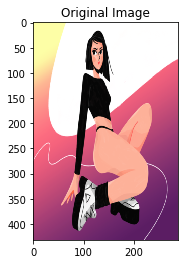

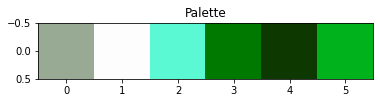

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


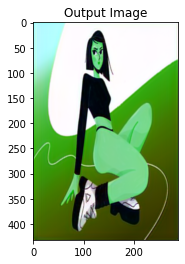

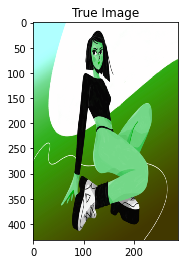

In [17]:
# load model from saved model file
state = torch.load("/home/jovyan/work/saved_models/FE_RD.pth")
FE = FeatureEncoder().float().to(device)
RD = RecoloringDecoder().float().to(device)
FE.load_state_dict(state['FE'])
RD.load_state_dict(state['RD'])
optimizer.load_state_dict(state['optimizer'])

for i_batch, sampled_batched in enumerate(train_loader):
    ori_image, new_image, illu, new_palette, ori_palette = sampled_batched
    flat_palette = new_palette.flatten()
    c1, c2, c3, c4 = FE.forward(ori_image.float().to(device))
    out = RD.forward(c1, c2, c3, c4, flat_palette.float().to(device), illu.float().to(device))
    break

idx = 3
viz_image_ori_new_out(ori_image[idx], new_palette[idx], new_image[idx], out[idx])

## Adversarial Training

In [18]:
# discriminator model for adversarial training
class Discriminator(nn.Module):
    def __init__(self, input_channel):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channel, 64, kernel_size=4, stride=2)
        self.norm1 = nn.InstanceNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=4, stride=2)
        self.norm2 = nn.InstanceNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=4, stride=2)
        self.norm3 = nn.InstanceNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=4, stride=2)
        self.norm4 = nn.InstanceNorm2d(64)
        self.linear = nn.Linear(25600, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.norm1(self.conv1(x)))
        x = F.leaky_relu(self.norm2(self.conv2(x)))
        x = F.leaky_relu(self.norm3(self.conv3(x)))
        x = F.leaky_relu(self.norm4(self.conv4(x)))
        x = x.view(x.size(0), -1)  # flatten
        x = self.linear(x)
        return torch.sigmoid(x)

In [19]:
# load model from saved model file
state = torch.load("/home/jovyan/work/saved_models/FE_RD.pth")
FE = FeatureEncoder().float().to(device)
RD = RecoloringDecoder().float().to(device)
FE.load_state_dict(state['FE'])
RD.load_state_dict(state['RD'])
optimizer.load_state_dict(state['optimizer'])

# freeze FE
for param in FE.parameters(): 
    param.requires_grad = False

In [12]:
def merge(img, palette_1d):
    """
    replicating Palette spatially and concatenating in depth to the image.
    necessary for the adversarial training 
    """
    img = img.to(device)
    palette_1d = palette_1d.to(device)

    palette_1d = palette_1d.flatten()
    bz, h, w = img.shape[0], img.shape[2], img.shape[3]
    palettes = torch.ones(bz, 18, h, w).float().to(device)
    palettes = palettes.reshape(h, w, bz * 18) * palette_1d
    palettes = palettes.permute(2, 0, 1).reshape(bz, 18, h, w)

    # concatenate target_palettes with c1
    x = torch.cat((img.float(), palettes.float()), 1)
    return x

In [20]:
bz = 16
epoches = 1000
lr = 0.0002

# pre-processsing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((432, 288)),
    transforms.ToTensor(),
])

train_data = ColorTransferDataset(pathlib.Path("/home/jovyan/work/data/train"), transform)
train_loader = DataLoader(train_data, batch_size=bz)

D = Discriminator(input_channel=21).to(device)
adversarial_loss = torch.nn.BCELoss()
optimizer_G = torch.optim.Adam(RD.parameters(), betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), betas=(0.5, 0.999))
train_loader = DataLoader(train_data, batch_size=bz)

In [ ]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
lambda_MSE_loss = 10

min_g_loss = float('inf')
for e in range(epoches):
    total_g_loss = 0
    total_d_loss = 0
    for i_batch, sampled_batched in enumerate(tqdm(train_loader)):
        ori_image, new_image, illu, new_palette, ori_palette = sampled_batched
        flat_palette = new_palette.flatten()
        c1, c2, c3, c4 = FE.forward(ori_image.float().to(device))
        out_image = RD.forward(c1, c2, c3, c4, flat_palette.float().to(device), illu.float().to(device))

        valid = Variable(Tensor(ori_image.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(new_image.size(0), 1).fill_(0.0), requires_grad=False)

        ori_i_new_p = merge(ori_image, new_palette)
        ori_i_ori_p = merge(ori_image, ori_palette)
        out_i_ori_p = merge(out_image, ori_palette)
        out_i_new_p = merge(out_image, new_palette)

        # generator loss
        optimizer_G.zero_grad()
        g_loss = adversarial_loss(D(out_i_new_p), valid) + lambda_MSE_loss * criterion(out_image, new_image.float().to(device))
        g_loss.backward()
        optimizer_G.step()

        # discriminator loss
        real_loss = adversarial_loss(D(ori_i_ori_p), valid)
        fake_loss = adversarial_loss(D(ori_i_new_p.detach()), fake) + adversarial_loss(D(out_i_ori_p.detach()), fake) + adversarial_loss(D(out_i_new_p.detach()), fake)

        optimizer_D.zero_grad()
        d_loss = (real_loss + fake_loss) / 4
        d_loss.backward()
        optimizer_D.step()

        total_g_loss += g_loss
        total_d_loss += d_loss
    
    if total_g_loss < min_g_loss:
        min_g_loss = total_g_loss
        state = {
            'epoch': e,
            'FE': FE.state_dict(),
            'RD': RD.state_dict(),
            'D': D.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, "/home/jovyan/work/saved_models/adv_FE_RD.pth")
    
    print(f"{e}: Generator loss of {total_g_loss:.3f}; Discrimator loss of {total_d_loss:.3f}")
        


 14%|█▎        | 3/22 [00:07<00:49,  2.59s/it]


KeyboardInterrupt: 

torch.Size([16, 3, 432, 288]) torch.Size([16, 432, 288]) torch.Size([16, 18])


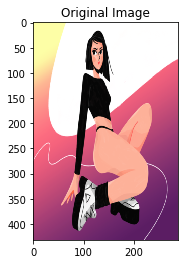

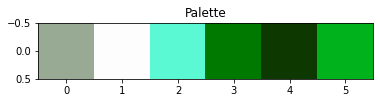

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


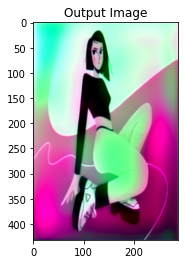

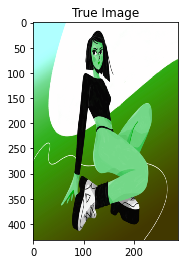

In [21]:
# load model from saved model file
state = torch.load("/home/jovyan/work/saved_models/adv_FE_RD.pth")
FE = FeatureEncoder().float().to(device)
RD = RecoloringDecoder().float().to(device)
FE.load_state_dict(state['FE'])
RD.load_state_dict(state['RD'])
optimizer.load_state_dict(state['optimizer'])

for i_batch, sampled_batched in enumerate(train_loader):
    ori_image, new_image, illu, new_palette, ori_palette = sampled_batched
    print(ori_image.shape, illu.shape, new_palette.shape)
    flat_palette = new_palette.flatten()
    c1, c2, c3, c4 = FE.forward(ori_image.float().to(device))
    out = RD.forward(c1, c2, c3, c4, flat_palette.float().to(device), illu.float().to(device))
    break

idx = 3
viz_image_ori_new_out(ori_image[idx], new_palette[idx], new_image[idx], out[idx])